# Assignment 4: Feature points, matching, homography

### Exercise 1: Feature points detectors

#### (a) Hessian detector

Q: What kind of structures are detected by the algorithm? How does the parameter sigma affect the result? \
A: Corners. Changes the size of corners detected.

In [470]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [471]:
def normalize(xs):
    res = [abs(x) for x in xs]
    return xs / np.sum(res)
    
def gaussdx(sigma):
    return np.array(normalize([(-1/(np.sqrt(2 * np.pi) * sigma**3)) * x * np.exp(-x**2 / (2 * sigma**2)) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)]))

In [472]:
def gaussian_kernel(sigma):
    return np.array([1 / (np.sqrt(2*np.pi) * sigma) * np.exp((-np.square(x)) / (2 * np.square(sigma))) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)])

In [473]:
def derive_1(img, sigma):
    img = img.astype(np.float64)

    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    # switch x and y because filter2D will use (256, ) shape as (1, 256)
    gx, gy, d_gx, d_gy = gy, gx, d_gy, d_gx
    
    dx_img = cv2.filter2D(cv2.filter2D(img, -1, gy), -1, d_gx)
    dy_img = cv2.filter2D(cv2.filter2D(img, -1, gx), -1, d_gy)
    
    return dx_img, dy_img

def derive_2(img, sigma):
    #img = img.astype(np.float64)
    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    dx_img, dy_img = derive_1(img, sigma)
    
    dx_img = cv2.filter2D(dx_img, -1, gx)
    dy_img = cv2.filter2D(dy_img, -1, gy)
    
    # switch x and y because filter2D will use (256, ) shape as (1, 256)
    dxx_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gx), -1, d_gy)
    dxy_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gy), -1, d_gx)
    dyy_img = cv2.filter2D(cv2.filter2D(dy_img, -1, gx), -1, d_gy)
    
    return dxx_img, dxy_img, dyy_img


In [474]:
def nonmaxima_suppression(img, boxsize, thresh=0.004):
    res = img.copy()
    for i in range(1,img.shape[0]-boxsize):
        for j in range(1,img.shape[1]-boxsize):                
            neighborhood = [img[i-boxsize,j-boxsize], img[i-boxsize,j], img[i-boxsize, j+boxsize],
                    img[i,j-boxsize], img[i,j+boxsize], 
                    img[i+boxsize,j-boxsize], img[i+boxsize,j], img[i+boxsize,j+boxsize]]
            
            # Check if its the strongest
            if np.max(neighborhood) > res[i,j]:
                # Remove multiple maximums
                if np.max(neighborhood) == img[i,j]:
                    np.where(neighborhood == res[i,j], 0, res[i,j])
                
                res[i,j] = 0
    return res
            

In [475]:
def hessian_points(img, sigma=3, thresh=0.004):
    '''
        Takes in grayscale image, return Hessian determinant
    '''
    Ixx, Ixy, Iyy = derive_2(img, sigma)
    
    det = Ixx * Iyy - np.square(Ixy)
    det[det < thresh] = 0
    return det   

In [476]:
def plot_points(img, thresh):
    '''
        Takes in image determinant and plots all points on the original image
    '''
    xs = []
    ys = []
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
           if img[y,x] > thresh:
               xs.append(x)
               ys.append(y)
    return xs, ys 

In [477]:
img_test_orig = cv2.imread("data/graf/graf_a.jpg")
img_test_orig = cv2.cvtColor(img_test_orig, cv2.COLOR_BGR2GRAY)

n_neighbors = 3

# Sigma = 3
det_test_3 = hessian_points(img_test_orig, 3)
det_test_3 = nonmaxima_suppression(det_test_3, n_neighbors)

# Sigma = 6
det_test_6 = hessian_points(img_test_orig, 6)
det_test_6 = nonmaxima_suppression(det_test_6, n_neighbors)

# Sigma = 9
det_test_9 = hessian_points(img_test_orig, 9)
det_test_9 = nonmaxima_suppression(det_test_9, n_neighbors)

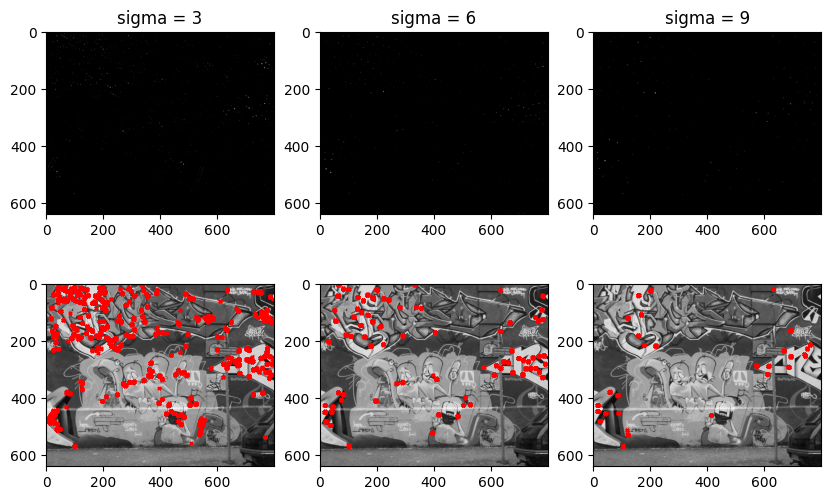

In [478]:
fig, ax = plt.subplots(2,3,figsize=(10,6))

xs3, ys3 = plot_points(det_test_3, 50)
ax[0,0].imshow(det_test_3, cmap="gray")
ax[0,0].set_title("sigma = 3")

ax[1,0].scatter(xs3, ys3, marker="x", c="red", s=5)
ax[1,0].imshow(img_test_orig, cmap="gray")

xs6, ys6 = plot_points(det_test_6, 50)
ax[0,1].imshow(det_test_6, cmap="gray")
ax[0,1].set_title("sigma = 6")

ax[1,1].scatter(xs6, ys6, marker="x", c="red", s=5)
ax[1,1].imshow(img_test_orig, cmap="gray")

xs9, ys9 = plot_points(det_test_9, 50)
ax[0,2].imshow(det_test_9, cmap="gray" )
ax[0,2].set_title("sigma = 9")

ax[1,2].scatter(xs9, ys9, marker="x", c="red", s=5)
ax[1,2].imshow(img_test_orig, cmap="gray")

#### (b) Harris detector

In [479]:
smoothing_sigma_factor = 1.6

In [480]:
def C_mat(img, sigma):
    i = img.copy()
    Ix, Iy = derive_1(i, sigma * smoothing_sigma_factor)
        
    # smoothe img with gauss
    kernel = gaussian_kernel(sigma * smoothing_sigma_factor)
    kernel_T = np.reshape(kernel, (1, -1))
    i = cv2.filter2D(i, -1, kernel)
    
    # Get values
    sxx = cv2.filter2D(cv2.filter2D(np.square(Ix), -1, kernel), -1, kernel_T)
    sxy = cv2.filter2D(cv2.filter2D((Ix * Iy), -1, kernel), -1, kernel_T);
    syy = cv2.filter2D(cv2.filter2D(np.square(Iy), -1, kernel.T), -1, kernel_T)
    
    
    return np.array([[sxx, sxy], [sxy, syy]]) 

In [503]:
def check_corner(img_orig, C, thresh):
    img = img_orig.copy()
    alpha = 0.06
    
    det = (C[0,0] * C[1,1]) - np.square(C[1,0])
    trace = C[0,0] + C[1,1]
        
    #img[det - alpha * np.square(trace) < thresh] = 0        

    return det - alpha * np.square(trace) #img

In [482]:
n_neighbors = 6
thresh = 1e-7

C3 = C_mat(img_test_orig, 3)
corner_map3 = check_corner(img_test_orig, C3, thresh)
corner_map3 = nonmaxima_suppression(corner_map3, n_neighbors)
#corner_map3 /= np.max(corner_map3)

C6 = C_mat(img_test_orig, 6)
corner_map6 = check_corner(img_test_orig, C6, thresh)
corner_map6 = nonmaxima_suppression(corner_map6, n_neighbors)
#corner_map6 /= np.max(corner_map6)

C9 = C_mat(img_test_orig, 9)
corner_map9 = check_corner(img_test_orig, C9, thresh)
corner_map9 = nonmaxima_suppression(corner_map9, n_neighbors)
#corner_map9 /= np.max(corner_map9)

40268.616758873824
33955.13209021718
31270.10719545165


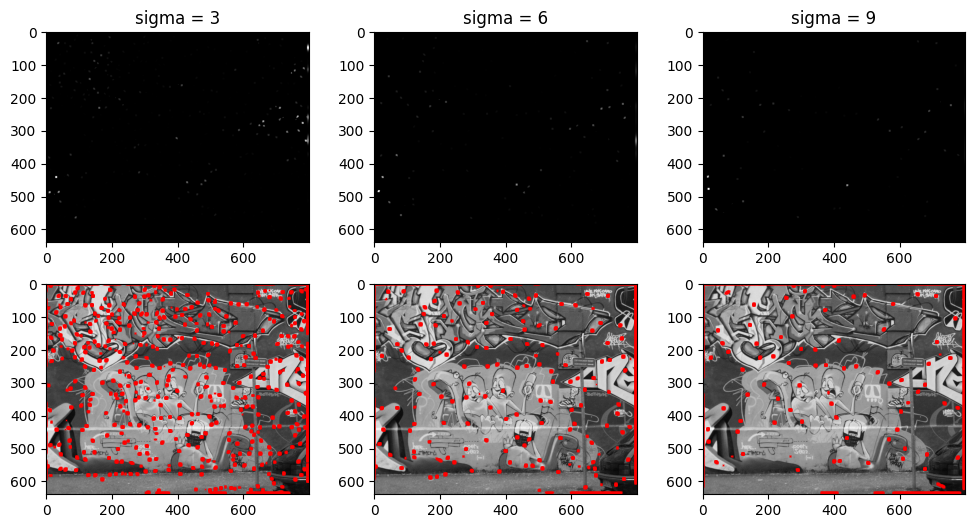

In [538]:
thresh = 70

fig, ax = plt.subplots(2, 3, figsize=(12,6))

xs3, ys3 = plot_points(corner_map3, thresh)
ax[0,0].imshow(corner_map3, cmap="gray")
ax[0,0].set_title("sigma = 3")

ax[1,0].scatter(xs3, ys3, marker="x", c="r", s=.1)
ax[1,0].imshow(img_test_orig, cmap="gray")


xs6, ys6 = plot_points(corner_map6, thresh)
ax[0,1].imshow(corner_map6, cmap="gray")
ax[0,1].set_title("sigma = 6")

ax[1,1].scatter(xs6, ys6, marker="x", c="r", s=.1)
ax[1,1].imshow(img_test_orig, cmap="gray")


xs9, ys9 = plot_points(corner_map9, thresh)
ax[0,2].imshow(corner_map9, cmap="gray")
ax[0,2].set_title("sigma = 9")

ax[1,2].scatter(xs9, ys9, marker="x", c="r", s=.1)
ax[1,2].imshow(img_test_orig, cmap="gray")

### Exercise 2: Matching local regions

#### (a) Finding correspondences

In [504]:
from a4_utils import *

In [505]:
def hellinger(h1, h2):
    return np.sqrt(0.5 * np.sum(np.square(np.sqrt(h1) - np.sqrt(h2))))

In [506]:
def find_correspondences(descriptor1, descriptor2):
    '''
        Takes in 2 arrays of feature point descriptors and matches each one from the first array to the closest one from the second one
        Returns an array of pairs of indices
    '''
    indices = []
    for i in range(len(descriptor1)):
        d1 = descriptor1[i]
        
        min_dist = 10000;
        min_desc = -1
              
        for j in range(len(descriptor2)):
            d2 = descriptor2[j]
            
            dist = hellinger(d1, d2)
            if dist < min_dist:
                min_dist = dist
                min_desc = j
        indices.append((i, min_desc))
    return indices

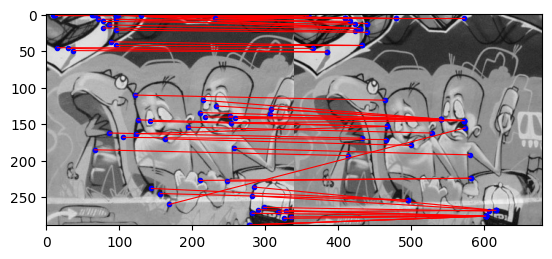

In [507]:
# Read in the images
img_a = cv2.imread("data/graf/graf_a_small.jpg")
img_b = cv2.imread("data/graf/graf_b_small.jpg")

img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

determinant_thresh = 25
sigma = 3
n_neighbors = 1

# Get feature points
det_a = hessian_points(img_a, sigma)
det_a = nonmaxima_suppression(det_a, n_neighbors)
a_xs, a_ys = plot_points(det_a, determinant_thresh)

det_b = hessian_points(img_b, sigma)
det_b = nonmaxima_suppression(det_b, n_neighbors)
b_xs, b_ys = plot_points(det_b, determinant_thresh)

img_a = img_a.astype(np.float64) / 255
img_b = img_b.astype(np.float64) / 255

# Get descriptors for found feature points
desc1 = simple_descriptors(img_a, a_ys, a_xs)
desc2 = simple_descriptors(img_b, b_ys, b_xs)

# Match closest descriptors
indices = find_correspondences(desc1, desc2)

# Get x and y coordinates
feature_points_a, feature_points_b = [], []

for index in indices:
    feature_points_a.append([a_xs[index[0]], a_ys[index[0]]])
    feature_points_b.append([b_xs[index[1]], b_ys[index[1]]])

# Display results
display_matches(img_a, feature_points_a, img_b, feature_points_b)

#### (b) Feature point matching

In [508]:
def harris(img, sigma, thresh):
    C = C_mat(img, sigma)
    corner_map = check_corner(img, C, thresh)
    corner_map = nonmaxima_suppression(corner_map, 8)
    corner_map /= np.max(corner_map)
    xs, ys = plot_points(corner_map, .05)
    
    return np.array([xs, ys])

In [509]:
def hessian(img, sigma, thresh):
    # Get feature points
    det_a = hessian_points(img, thresh, sigma)
    det_a = nonmaxima_suppression(det_a, 6)
    xs, ys = plot_points(det_a, 30)
    
    return np.array([xs, ys])

In [510]:
def get_symmetrical_correspondences(i1, i2):
    '''
        Returns an array of only the symmetrical matches of indices
        if i1[x] = y then i2[y] = x 
    '''
    
    correspondences = []
    
    for pair in i1:
        reverse = pair[::-1]
        if reverse in i2:
            correspondences.append(pair)     
                
    return correspondences   

In [511]:
def find_matches(img1, img2, sigma, detector="hessian"):
    '''
        Takes in 2 images and returns array of index pairs
    '''

    # Get feature points
    if detector == "harris":
        fpoints1 = harris(img1, sigma, 1e-5)
        fpoints2 = harris(img2, sigma, 1e-5)
    
    # Get feature points
    if detector == "hessian":
        fpoints1 = hessian(img1, sigma, 40)
        fpoints2 = hessian(img2, sigma, 40)
    
    print("Got fpoints", fpoints1.shape)
    
    img1 = img1.astype(np.float64) / 255
    img2 = img2.astype(np.float64) / 255
    
    # Get simple descriptors
    desc1 = simple_descriptors(img1, fpoints1[1], fpoints1[0])
    desc2 = simple_descriptors(img2, fpoints2[1], fpoints2[0])
    print("Got descriptors")
    
    # Find corresponding descriptors
    indices1 = find_correspondences(desc1, desc2)
    indices2 = find_correspondences(desc2, desc1)
    
    indices = get_symmetrical_correspondences(indices1, indices2)
    print("Got indices")    

    # Get x and y coordinates
    feature_points_a, feature_points_b = [], []

    for index in indices:
        feature_points_a.append([fpoints1[0][index[0]], fpoints1[1][index[0]]])
        feature_points_b.append([fpoints2[0][index[1]], fpoints2[1][index[1]]])
        
    display_matches(img1, feature_points_a, img2, feature_points_b)
    return np.array(feature_points_a), np.array(feature_points_b)

Got fpoints (2, 1701)
Got descriptors
Got indices


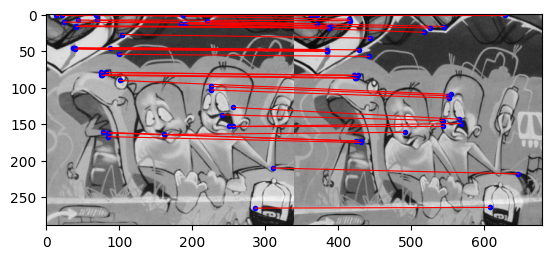

(array([[ 13,   0],
        [ 21,   0],
        [ 68,   0],
        [187,   0],
        [ 43,   7],
        [ 69,   7],
        [220,   9],
        [ 24,  10],
        [184,  12],
        [190,  12],
        [ 41,  15],
        [ 41,  16],
        [104,  27],
        [ 37,  45],
        [ 87,  45],
        [ 38,  46],
        [ 39,  46],
        [ 39,  47],
        [ 99,  54],
        [ 75,  79],
        [ 82,  79],
        [ 75,  82],
        [ 76,  83],
        [101,  90],
        [226,  98],
        [226, 103],
        [256, 127],
        [241, 137],
        [250, 152],
        [256, 153],
        [ 77, 161],
        [ 85, 162],
        [161, 164],
        [ 85, 167],
        [310, 210],
        [286, 265]]),
 array([[ 22,   0],
        [ 31,   0],
        [ 75,   6],
        [288,   0],
        [ 50,  15],
        [ 76,   8],
        [205,  16],
        [ 31,  12],
        [178,  24],
        [186,  18],
        [ 48,  17],
        [ 48,  18],
        [104,  32],
        [ 44,  48]

In [524]:
img_a = cv2.imread("data/graf/graf_a_small.jpg")
img_b = cv2.imread("data/graf/graf_b_small.jpg")

img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

find_matches(img_a, img_b, 3, "harris")

Q: What do you notice when visualizing the correspondences? How accurate are the matches? \
A: A lot of areas have lots of corresponding points close together (not eliminated by non maxima suppression), so they are still clustered together, whereas some of the weak correspondences are lost, because they might not be symmetrical or not strong enough. The matches that do remain are relatively accurate.

### Exercise 3: Homography estimation

Q: Looking at the equation above, which parameters account for translation and which for rotation and scale? \
A: p1 is parameter for rotation, p2 for scaling and p3 and p4 are translation parameters

Q: Write down a sketch of an algorithm to determine similarity transform from a set of point correspondences \
`P = [(x r1 , x t1 ), (x r2 , x t2 ), . . . (x rn , x tn )]`. For more details consult the lecture notes.

In [513]:
def get_Ai(src_point, dest_point):
    x_r, y_r = src_point
    x_t, y_t = dest_point
    z_r, z_t = 1, 1         # Homogenous coord
    
    # 2x9 Matrix
    A_partial = np.array([
        [x_r, y_r, 1, 0, 0, 0, -x_t * x_r, -x_t * y_r, -x_t],
        [0, 0, 0, x_r, y_r, 1, -y_t * x_r, -y_t * y_r, -y_t]
    ])
    return A_partial

In [514]:
def get_A(points1, points2):
    '''
        Piles Ai matrices on top of each other to gain matrix A
    '''
    A = []
    
    for i in range(points1.shape[0]):
        Ai = get_Ai(points1[i], points2[i])
        A.append(Ai)
        
    # We need 2D matrix not 3D
    return np.concatenate(A, axis=0)

    

In [515]:
def estimate_homography(fpoints):
    # Construct A by Ah = 0
    A = get_A(fpoints[0], fpoints[1])
    
    # SVD -> U, S, VT = np.linalg.svd(A)
    U, S, VT = np.linalg.svd(A)

    # Compute h
    h = VT[-1].reshape((3,3))
    h /= h[2,2]
    
    return h 

[[ 7.68066321e-01 -6.37561940e-01  1.08599883e+02]
 [ 6.42462642e-01  7.41785866e-01 -3.30904536e+01]
 [ 2.51437379e-05 -8.30833330e-05  1.00000000e+00]]


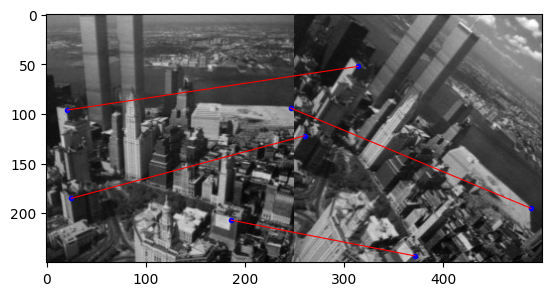

In [516]:
img1 = cv2.imread("data/newyork/newyork_a.jpg")
img2 = cv2.imread("data/newyork/newyork_b.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2  = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

points = np.loadtxt("data/newyork/newyork.txt")

# x1, y1
fpoints1 = []
# x2, y2
fpoints2 = []

for point in points:
    fpoints1.append([point[0], point[1]])
    fpoints2.append([point[2], point[3]])

fpoints = np.array([fpoints1, fpoints2])
H = estimate_homography(fpoints)
print(H)
display_matches(img1, fpoints1, img2, fpoints2)

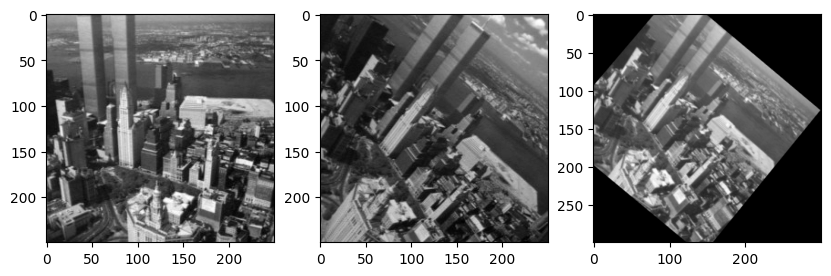

In [517]:
img = cv2.warpPerspective(img1, H, (300,300))
fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].imshow(img1, cmap="gray")
ax[1].imshow(img2, cmap="gray")
ax[2].imshow(img, cmap="gray")

####  (b) Detection and RANSAC

In [518]:
def euclidean(h1, h2):
    return np.sqrt(np.sum(np.square(h1 - h2)))

In [519]:
def get_reprojection_error(fpoints, H):
    fpoints1, fpoints2 = fpoints
    
    prices = []
    iter = 0
    for point in fpoints1:
        #               x1          Hx1         y1          Hy1
        transformed = [point[0] * H[iter][0], point[1] * H[iter][1]]
        prices.append(euclidean(transformed, fpoints2[iter]))
    
    return np.average(prices)

In [520]:
def get_inliers(fpoints1, fpoints2, H, thresh=100):
    inliers = []
    
    for i in range(len(fpoints1)):
        cost = get_reprojection_error(fpoints1[i], fpoints2[i], H)
        if cost < thresh:
            inliers.append(fpoints1[i], fpoints2[i])
            
    return inliers

In [533]:
def ransac(img1, img2, thresh: float or int, n_iter: int = 10):
    fpoints1, fpoints2 = find_matches(img1, img2, 3, "hessian")
    print(fpoints1, fpoints2)
    
    best_inliers, best_H = None, None
    min_error = 10000
    
    indices = []

    # Get 4 random points
    indices = np.random.randint(fpoints1.shape[0], size=4)
    inliers = np.array([fpoints1[indices], fpoints2[indices]]) 
        
    for i in range(n_iter):
                
        H = estimate_homography(inliers)
        H_error = get_reprojection_error([fpoints1, fpoints2], H)
        if H_error < min_error:
            min_error = H_error
            best_H = H
            best_inliers = inliers
        
        warped = cv2.warpPerspective(img1, H, (img1.shape[0], img1.shape[1]))
        
        fpoints1, fpoints2 = find_matches(warped, img2, 3, "hessian")
        
        inliers = get_inliers(fpoints1, fpoints2, H, 100)
        if len(inliers) == 0:
            return best_H
        
        # Determine cost, if enough then use those inliers to get a new H
        
        # Save best
        
        # Do k times
    
    print(min_error)
    return best_H
    
    
            

Got fpoints (2, 1083)
Got descriptors
Got indices


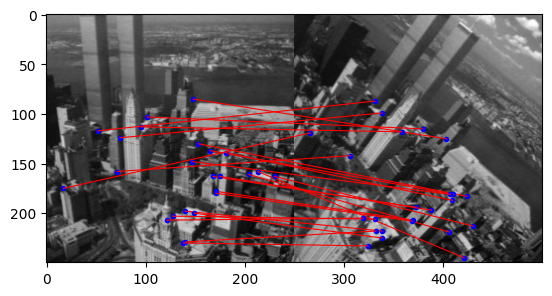

In [541]:
img1 = cv2.imread("data/newyork/newyork_a.jpg")
img2 = cv2.imread("data/newyork/newyork_b.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2  = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fpoints1, fpoints2 = find_matches(img1, img2, 3, "harris")

Got fpoints (2, 0)
Got descriptors
Got indices


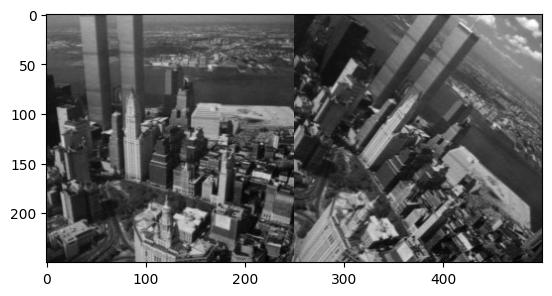

[] []


ValueError: high <= 0

In [540]:
H = ransac(img1,img2, 10, 10)

print(H)
#img1 = img1.astype(np.uint8)
warped = cv2.warpPerspective(img1, H, (img1.shape[0], img1.shape[1]))
plt.imshow(warped, cmap="gray")